<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Material_Generating_Graphene_EM_Images_(GANs)_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Generating Graphene EM Images using Generative Adversarial Networks (GANs).

In this notebook, we attempt to build Generative Adversarial Networks (GANs) to generate new samples plausibly drawn from the training dataset.

Inelastic neutron scattering (INS) can be used to infer information about the forces present in a material. Neutrons scatter off a sample, exchanging energy with certain fundamental vibrational modes of the sample. These vibraional modes include phonons (interatomic boding forces) and magnons (spin coupling between magnetic nuclei).

[Johnstone et al. (2012)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.109.237202) have simulated magnon spectra from a double perovskite systems, where INS was used to distinguish between two possible magnetic Hamiltonians of the system. For this practical, we have simulated datasets for each of the possible Hamiltonians. We are going to train a CNN to classify the system correctly.


The aim of this work is to generate more diverse data that are plausibly drawn from the training dataset using GANs.

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import urllib.request
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'ins-data')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/ins-data/"
files_to_download = ["train.h5"]

In [3]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data


The INS dataset contains 20,000 images. This number is insufficient to train a GAN, given that the images are of high variability. Each image has a shape of `(20, 200)`, as composed of 10 images with shape `(20, 20)` in a row. To maximise the number of data, we divide one original image into 10 sub-images and filter out the weak ones. Finally, we obtain a dataset with 129,228 images.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# read original images
with h5py.File(join(data_path, 'ins-data/train.h5'), 'r') as handle:
    big_images = handle['images'][:]
    
# divide into 10 sub-images
n = big_images.shape[0]
sub_images = np.moveaxis(big_images.reshape([n, 20, 10, 20]), 2, 1).reshape(n * 10, 20, 20, 1)
    
# plot an image and its sub-images
index = 0
plt.figure(dpi=200)
plt.imshow(big_images[index, :, :, 0])
plt.gca().set_aspect(1.)
plt.axis('off')
plt.show()
fig, ax = plt.subplots(1, 10, dpi=200)
for i in range(10):
    ax[i].imshow(sub_images[index * 10 + i, :, :, 0], vmin=0, vmax=1)
    ax[i].set_aspect(1.)
    ax[i].axis('off')
plt.show()

# remove weak ones: max pixel smaller than a given threshold
threshold = 0.5
x_train = sub_images[np.where(np.max(sub_images, axis=(1, 2, 3)) > threshold)]

# normalize to [-1, 1]
x_train = x_train * 2 - 1

# print size info
print(f'Shape of original dataset: {big_images.shape}')
print(f'Shape of divided dataset: {sub_images.shape}')
print(f'Shape of training dataset: {x_train.shape}')
```
    
</p>
</details>


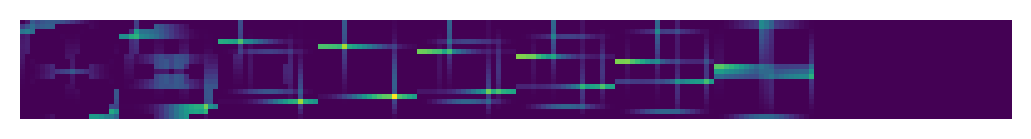

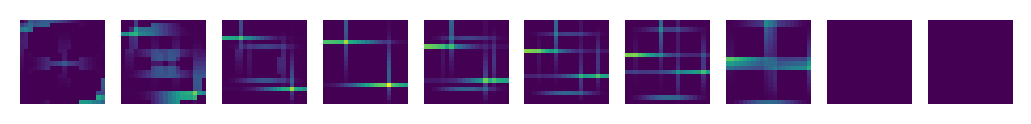

Shape of original dataset: (20000, 20, 200, 1)
Shape of divided dataset: (200000, 20, 20, 1)
Shape of training dataset: (129228, 20, 20, 1)


In [4]:
# read original images
with h5py.File(join(data_path, 'ins-data/train.h5'), 'r') as handle:
    big_images = handle['images'][:]

# divide into 10 sub-images
n = big_images.shape[0]
sub_images = np.moveaxis(big_images.reshape([n, 20, 10, 20]), 2, 1).reshape(n * 10, 20, 20, 1)

# plot an image and its sub-images
index = 0
plt.figure(dpi=200)
plt.imshow(big_images[index, :, :, 0])
plt.gca().set_aspect(1.)
plt.axis('off')
plt.show()
fig, ax = plt.subplots(1, 10, dpi=200)
for i in range(10):
    ax[i].imshow(sub_images[index * 10 + i, :, :, 0], vmin=0, vmax=1)
    ax[i].set_aspect(1.)
    ax[i].axis('off')
plt.show()

# remove weak ones: max pixel smaller than a given threshold
threshold = 0.5
x_train = sub_images[np.where(np.max(sub_images, axis=(1, 2, 3)) > threshold)]

# normalize to [-1, 1]
x_train = x_train * 2 - 1

# print size info
print(f'Shape of original dataset: {big_images.shape}')
print(f'Shape of divided dataset: {sub_images.shape}')
print(f'Shape of training dataset: {x_train.shape}')

Next, we can create a dataset with the new image set:

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(256)

---

# 2. Build the network

Our image size is `(20, 20)`. We will first build a generator and then a discriminator. The output of the generator and the input of the discriminator should have the same size as the image.


### The generator

The generator takes random noise as inputs and outputs synthetic images, which has the same size with the images in the training dataset.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
def make_generator_model(noise_size=100, image_size=(20,20), n_filters=(256,128,64)):
    '''
    Create a generator, hardcoded with three Conv2DTranspose layers.

    :param noise_size: size of the seed vector
    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the generator model
    '''

    # sequential model
    model = tf.keras.Sequential()

    w = image_size[0] // 4
    h = image_size[1] // 4
    model.add(layers.Dense(w*h*n_filters[0], use_bias=False,
                           input_shape=(noise_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((w, h, n_filters[0])))

    model.add(layers.Conv2DTranspose(n_filters[1], (5, 5), strides=(1, 1),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(n_filters[2], (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False, activation='tanh'))

    return model

# noise size
NOISE_SIZE = 100

# create a generator
generator = make_generator_model(noise_size=NOISE_SIZE, image_size=(20, 20),
                                 n_filters=(256,128,64))
```
    
</p>
</details>


In [7]:
def make_generator_model(noise_size=100, image_size=(20,20), n_filters=(256,128,64)):
    '''
    Create a generator, hardcoded with three Conv2DTranspose layers.

    :param noise_size: size of the seed vector
    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the generator model
    '''

    # sequential model
    model = tf.keras.Sequential()

    w = image_size[0] // 4
    h = image_size[1] // 4
    model.add(layers.Input(shape=(noise_size,)))
    model.add(layers.Dense(w*h*n_filters[0], use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((w, h, n_filters[0])))

    model.add(layers.Conv2DTranspose(n_filters[1], (5, 5), strides=(1, 1),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(n_filters[2], (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False, activation='tanh'))

    return model

# noise size
NOISE_SIZE = 100

# create a generator
generator = make_generator_model(noise_size=NOISE_SIZE, image_size=(20, 20),
                                 n_filters=(256,128,64))

### The discriminator

The discriminator distinguish between images from the training dataset and outputs from the generator.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
def make_discriminator_model(image_size=(20,20), n_filters=(64,128)):
    '''
    Create a discriminator, hardcoded with two Conv2D layers.

    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the discriminator model
    '''

    # sequential model
    model = tf.keras.Sequential()

    w = image_size[0]
    h = image_size[1]
    model.add(layers.Conv2D(n_filters[0], (5, 5), strides=(2, 2), padding='same',
              input_shape=[w, h, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(n_filters[1], (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    return model

# create a discriminator
discriminator = make_discriminator_model(image_size=(20, 20), n_filters=(64,128))
```
    
</p>
</details>

In [9]:
def make_discriminator_model(image_size=(20,20), n_filters=(64,128)):
    '''
    Create a discriminator, hardcoded with two Conv2D layers.

    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the discriminator model
    '''

    # sequential model
    model = tf.keras.Sequential()

    w = image_size[0]
    h = image_size[1]
    model.add(layers.Input(shape=(w, h, 1)))
    model.add(layers.Conv2D(n_filters[0], (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(n_filters[1], (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    return model

# create a discriminator
discriminator = make_discriminator_model(image_size=(20, 20), n_filters=(64,128))

### Loss functions and optimizers

Create the loss functions and optimizers for the generator and discriminator.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# cross entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator's loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# generator's loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
```
    
</p>
</details>

In [10]:
# cross entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator's loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# generator's loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Training Loop

Implement the training function for a mini-batch.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_images, noise_size):
    # seed
    batch_size = real_images.shape[0]
    seed = tf.random.normal([batch_size, noise_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # fake images
        fake_images = generator(seed, training=True)

        # discriminate real
        real_score = discriminator(real_images, training=True)
        # discriminate fake
        fake_score = discriminator(fake_images, training=True)

        # compute losses
        gen_loss = generator_loss(fake_score)
        disc_loss = discriminator_loss(real_score, fake_score)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # apply gradients to update model parameters
        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        return gen_loss, disc_loss
```
    
</p>
</details>


In [11]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_images, noise_size):
    # seed
    batch_size = real_images.shape[0]
    seed = tf.random.normal([batch_size, noise_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # fake images
        fake_images = generator(seed, training=True)

        # discriminate real
        real_score = discriminator(real_images, training=True)
        # discriminate fake
        fake_score = discriminator(fake_images, training=True)

        # compute losses
        gen_loss = generator_loss(fake_score)
        disc_loss = discriminator_loss(real_score, fake_score)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # apply gradients to update model parameters
        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        return gen_loss, disc_loss

Now perform the training.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
############################
######### TRAINING #########
############################

# epochs
EPOCHS = 50

# epoch loop
tstart = time.time()
for epoch in range(EPOCHS):
    # batch loop
    for i, image_batch in enumerate(train_dataset):
        gen_loss, disc_loss = train_step(image_batch, NOISE_SIZE)
    # print loss after each epoch
    print(f'Epoch {epoch + 1} / {EPOCHS}, Elapsed = {time.time() - tstart:.2f} s, '
          f'Gen loss = {gen_loss:.2f}, Disc loss = {disc_loss:.2f}')
```
    
</p>
</details>

In [12]:
############################
######### TRAINING #########
############################

# epochs
EPOCHS = 50

# epoch loop
tstart = time.time()
for epoch in range(EPOCHS):
    # batch loop
    for i, image_batch in enumerate(train_dataset):
        gen_loss, disc_loss = train_step(image_batch, NOISE_SIZE)
    # print loss after each epoch
    print(f'Epoch {epoch + 1} / {EPOCHS}, Elapsed = {time.time() - tstart:.2f} s, '
          f'Gen loss = {gen_loss:.2f}, Disc loss = {disc_loss:.2f}')

Epoch 1 / 50, Elapsed = 22.39 s, Gen loss = 0.73, Disc loss = 1.41
Epoch 2 / 50, Elapsed = 36.06 s, Gen loss = 0.77, Disc loss = 1.35
Epoch 3 / 50, Elapsed = 49.97 s, Gen loss = 0.82, Disc loss = 1.21
Epoch 4 / 50, Elapsed = 64.02 s, Gen loss = 0.88, Disc loss = 1.25
Epoch 5 / 50, Elapsed = 78.50 s, Gen loss = 1.05, Disc loss = 0.96
Epoch 6 / 50, Elapsed = 92.73 s, Gen loss = 1.11, Disc loss = 0.98
Epoch 7 / 50, Elapsed = 107.08 s, Gen loss = 1.50, Disc loss = 0.76
Epoch 8 / 50, Elapsed = 121.53 s, Gen loss = 1.33, Disc loss = 0.84
Epoch 9 / 50, Elapsed = 136.07 s, Gen loss = 1.04, Disc loss = 1.11
Epoch 10 / 50, Elapsed = 150.70 s, Gen loss = 1.26, Disc loss = 0.87
Epoch 11 / 50, Elapsed = 165.39 s, Gen loss = 1.15, Disc loss = 1.01
Epoch 12 / 50, Elapsed = 180.16 s, Gen loss = 1.06, Disc loss = 0.86
Epoch 13 / 50, Elapsed = 194.99 s, Gen loss = 1.25, Disc loss = 0.91
Epoch 14 / 50, Elapsed = 209.88 s, Gen loss = 1.07, Disc loss = 1.07
Epoch 15 / 50, Elapsed = 224.77 s, Gen loss = 0.9

---

# 3. Analyse results

Visualize and comapre the generated images from the generator with images in the training dataset.  

Finally, use the trained generator to generate images from random noise.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# seed
nrows = 10
ncols = 10
seed = tf.random.normal([nrows * ncols, NOISE_SIZE])

# generate images
generated_image = generator(seed, training=False)

# plot images
plt.figure(dpi=100, figsize=(ncols, nrows))
for iplot in range(nrows * ncols):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(generated_image[iplot, :, :, 0])
    plt.xticks([])
    plt.yticks([])
plt.show()
```
    
</p>
</details>

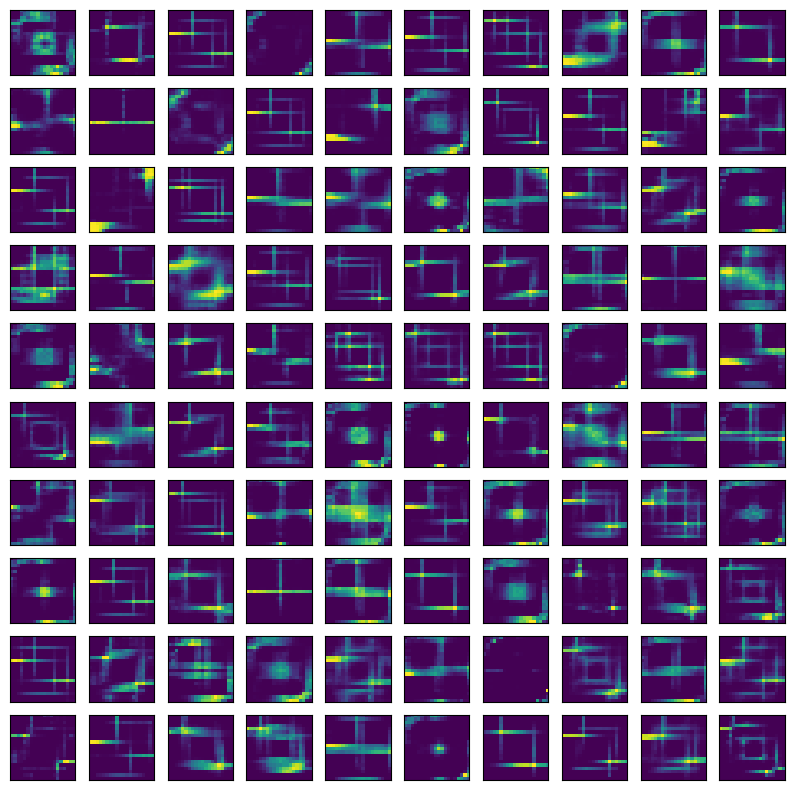

In [13]:
# seed
nrows = 10
ncols = 10
seed = tf.random.normal([nrows * ncols, NOISE_SIZE])

# generate images
generated_image = generator(seed, training=False)

# plot images
plt.figure(dpi=100, figsize=(ncols, nrows))
for iplot in range(nrows * ncols):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(generated_image[iplot, :, :, 0])
    plt.xticks([])
    plt.yticks([])
plt.show()

---

# 4. Exercise

* Change learning rates of a generator and a discriminator
* Try to use different loss functions to make learning GANs stable such as Wasserstein GAN
